# Maman 11 - Nir Dagan, 206957920

## Here we going to implement A single layer perceptron for multi-class classifcation problem of Digits.



First of all we will import all the python libaries that we need:

In [15]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


Now, we will retrieve the MNIST dataset, which consists of 28x28 pixel grayscale images of handwritten digits. This will be done using scikit-learn's fetch_openml function. Following this, we will preprocess the data by incorporating a bias term into the feature matrix and dividing it into training (60,000 samples) and testing (10,000 samples) sets. To facilitate their use in a single-layer perceptron model, categorical labels will be converted to one-hot encoding.

In [16]:
# Fetch MNIST dataset
mnist = fetch_openml('mnist_784', version=1, parser='auto')
# Access features (pixel values) and labels
X, y = mnist['data'], mnist.target

# adding one to the X for bias and changing to a numpy array
X = np.append(X, np.ones([len(X), 1]), 1)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, train_size=60000)
# Convert categorical labels to one-hot encoding
y_train_one_hot = pd.get_dummies(y_train)
y_test_one_hot = pd.get_dummies(y_test)
# Convert to a numpy array
y_train_one_hot_np = np.array(y_train_one_hot)
y_test_one_hot_np = np.array(y_test_one_hot)


An example of a digit -

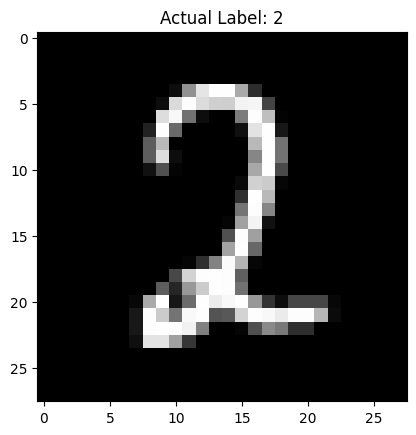

In [17]:
import random

# Select a random index
random_index = random.randint(0, len(X_test) - 1)

# Get the features (pixel values) of the selected digit
random_digit_features = X_test[random_index, :-1]

# Reshape the features into a 28x28 array
digit_image = random_digit_features.reshape(28, 28)

# Get the actual label of the selected digit
actual_label = y_test.iloc[random_index]

plt.imshow(digit_image, cmap='gray')
plt.title(f"Actual Label: {actual_label}")
plt.show()


# Perceptron Train Function

To conduct multi-class classification using the perceptron, we will employ a one-versus-all strategy. This entails establishing separate classifiers for each digit, discerning it from all other digits. For instance, the classifier for digit 0 will produce an output of 1 if the example is identified as the digit 0, and -1 for any other digit. This process is repeated for all 10 digits, resulting in the creation of 10 classifiers. During predictions, we select the classifier with the highest output value.

In the following cell, we will implement the training function for the perceptron using the pocket algorithm. This function will be applied independently to each digit to derive individual classifiers for multi-class classification.

In [18]:
# To see how much time it will take us.
from tqdm.notebook import tqdm

# Lists to store errors and weights for each digit for  visualization later.
training_errors_per_digit = [[] for _ in range(10)]
test_errors_per_digit = [[] for _ in range(10)]

def train_perceptron(digit, w_classifiers, epochs=300):
    """
    Train a perceptron classifier for a specific digit using the one-versus-all strategy.

    Parameters:
    - digit: The digit for which the classifier is trained.
    - w_classifiers: List of weight vectors for each digit's classifier.
    - epochs: Number of training epochs.

    Returns:
    Updated list of weight vectors after training.
    """
    training_errors_per_epoch = []  # To store the number of errors at each epoch for visualization later.
    test_errors_per_epoch = []  # To store the number of test data errors at each epoch for visualization later.

    # Prepare training and test set for the specific digit
    y_training_set = np.where(y_train_one_hot_np[:, digit] == 1, 1, -1)
    y_test_set = np.where(y_test_one_hot_np[:, digit] == 1, 1 , -1)

    # Initialize variables for the pocket algorithim
    num_of_errors = X_train.shape[0]
    best_w = w_classifiers[digit]

    # Training loop
    for epoch in tqdm(range(epochs)):
        # Training data predictions
        predictions_train = np.dot(X_train, w_classifiers[digit])
        labels_train = np.where(predictions_train == 0, -1, np.sign(predictions_train))
        misclassified_index = np.argmax(labels_train != y_training_set)

        # Update weights if there is a misclassification
        if misclassified_index != X_train.shape[1]:
            cur_weight = np.add(w_classifiers[digit], np.multiply(X_train[misclassified_index],
                                                                  y_training_set[misclassified_index]))
            cur_temp = np.dot(X_train, cur_weight)
            cur_predict_labels = np.where(cur_temp == 0, -1, np.sign(cur_temp))
            cur_errors = np.sum(cur_predict_labels != y_training_set)

            # Update the best weights if the current configuration results in fewer errors
            if cur_errors < num_of_errors:
                best_w = cur_weight
                num_of_errors = cur_errors
            w_classifiers[digit] = cur_weight

        # for visualization
        cur_test = np.dot(X_test, w_classifiers[digit])
        cur_predict_test = np.where(cur_test == 0, -1, np.sign(cur_test))
        cur_errors_tests = np.sum(cur_predict_test != y_test_set)

        training_errors_per_epoch.append(num_of_errors)
        test_errors_per_epoch.append(cur_errors_tests)

    # Store the best weights after training
    w_classifiers[digit] = best_w
    # Convert errors_per_epoch to a NumPy array and normalize by len(X_train)
    training_errors_per_digit[digit] = np.array(training_errors_per_epoch) / len(X_train)
    test_errors_per_digit[digit] = np.array(test_errors_per_epoch) / len(X_test)

    return w_classifiers

As you can see I choose to use the perceptron with the pocket algorithim.
The pocket algorithm is essential with the perceptron for MNIST digit data, which isn't linearly separable. Relying solely on the perceptron in each iteration may worsen the weight vector's performance. The pocket algorithm's adaptability, preserving the best weights, is crucial for handling complex boundaries and noisy datasets, ensuring better convergence and generalization to unseen examples.

In the cell below we will train a classifier for every digit with 300 epochs with the train data we fetched eariler.

In [19]:
w_classifiers = [np.zeros(len(X_train[0])) for _ in range(10)]
for digit in tqdm(range(10)):
    w_classifiers = train_perceptron(digit, w_classifiers)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

# Plotting Training Error Rate Per Epoch

In this section, we visualize the error rate  and the error rate of the test data during training for each digit across multiple epochs. A few key observations can be made:


*   **Pocket Algorithm's Impact**:
Due to the nature of the pocket algorithm, the error rate of the training data consistently improves or remains the same as we progress through the epochs. This behavior is indicative of the algorithm's ability to refine its predictions over time.
*   **Digit-Specific Behavior**:
Some digits, such as 1 and 6, quickly achieve a low error rate after a relatively small number of epochs(on training and test data). Interestingly, for these digits, the error rate tends to stabilize, showing little improvement even with further epochs.
On the other hand, digits like 9 and 4 exhibit a slower convergence, requiring more epochs to reach a satisfactory error rate. Additionally, even after 200 epochs, the error rate for these digits may still be relatively high.

In conclusion, most digits demonstrate improved error rates with increasing epochs on both training and test data. Notably, the test data disruptions is similiar to the training data, indicating the model's proficiency in predicting similar patterns. It is reasonable to infer that further increasing epochs beyond 200 could lead to incremental improvements in algorithm performance.

P.S : The plot begins from the second epoch to highlight substantial improvements, as the first epoch typically exhibits numerous errors and a significant leap in performance. This allows a clearer visualization of the progressive improvement in error rate per epoch.






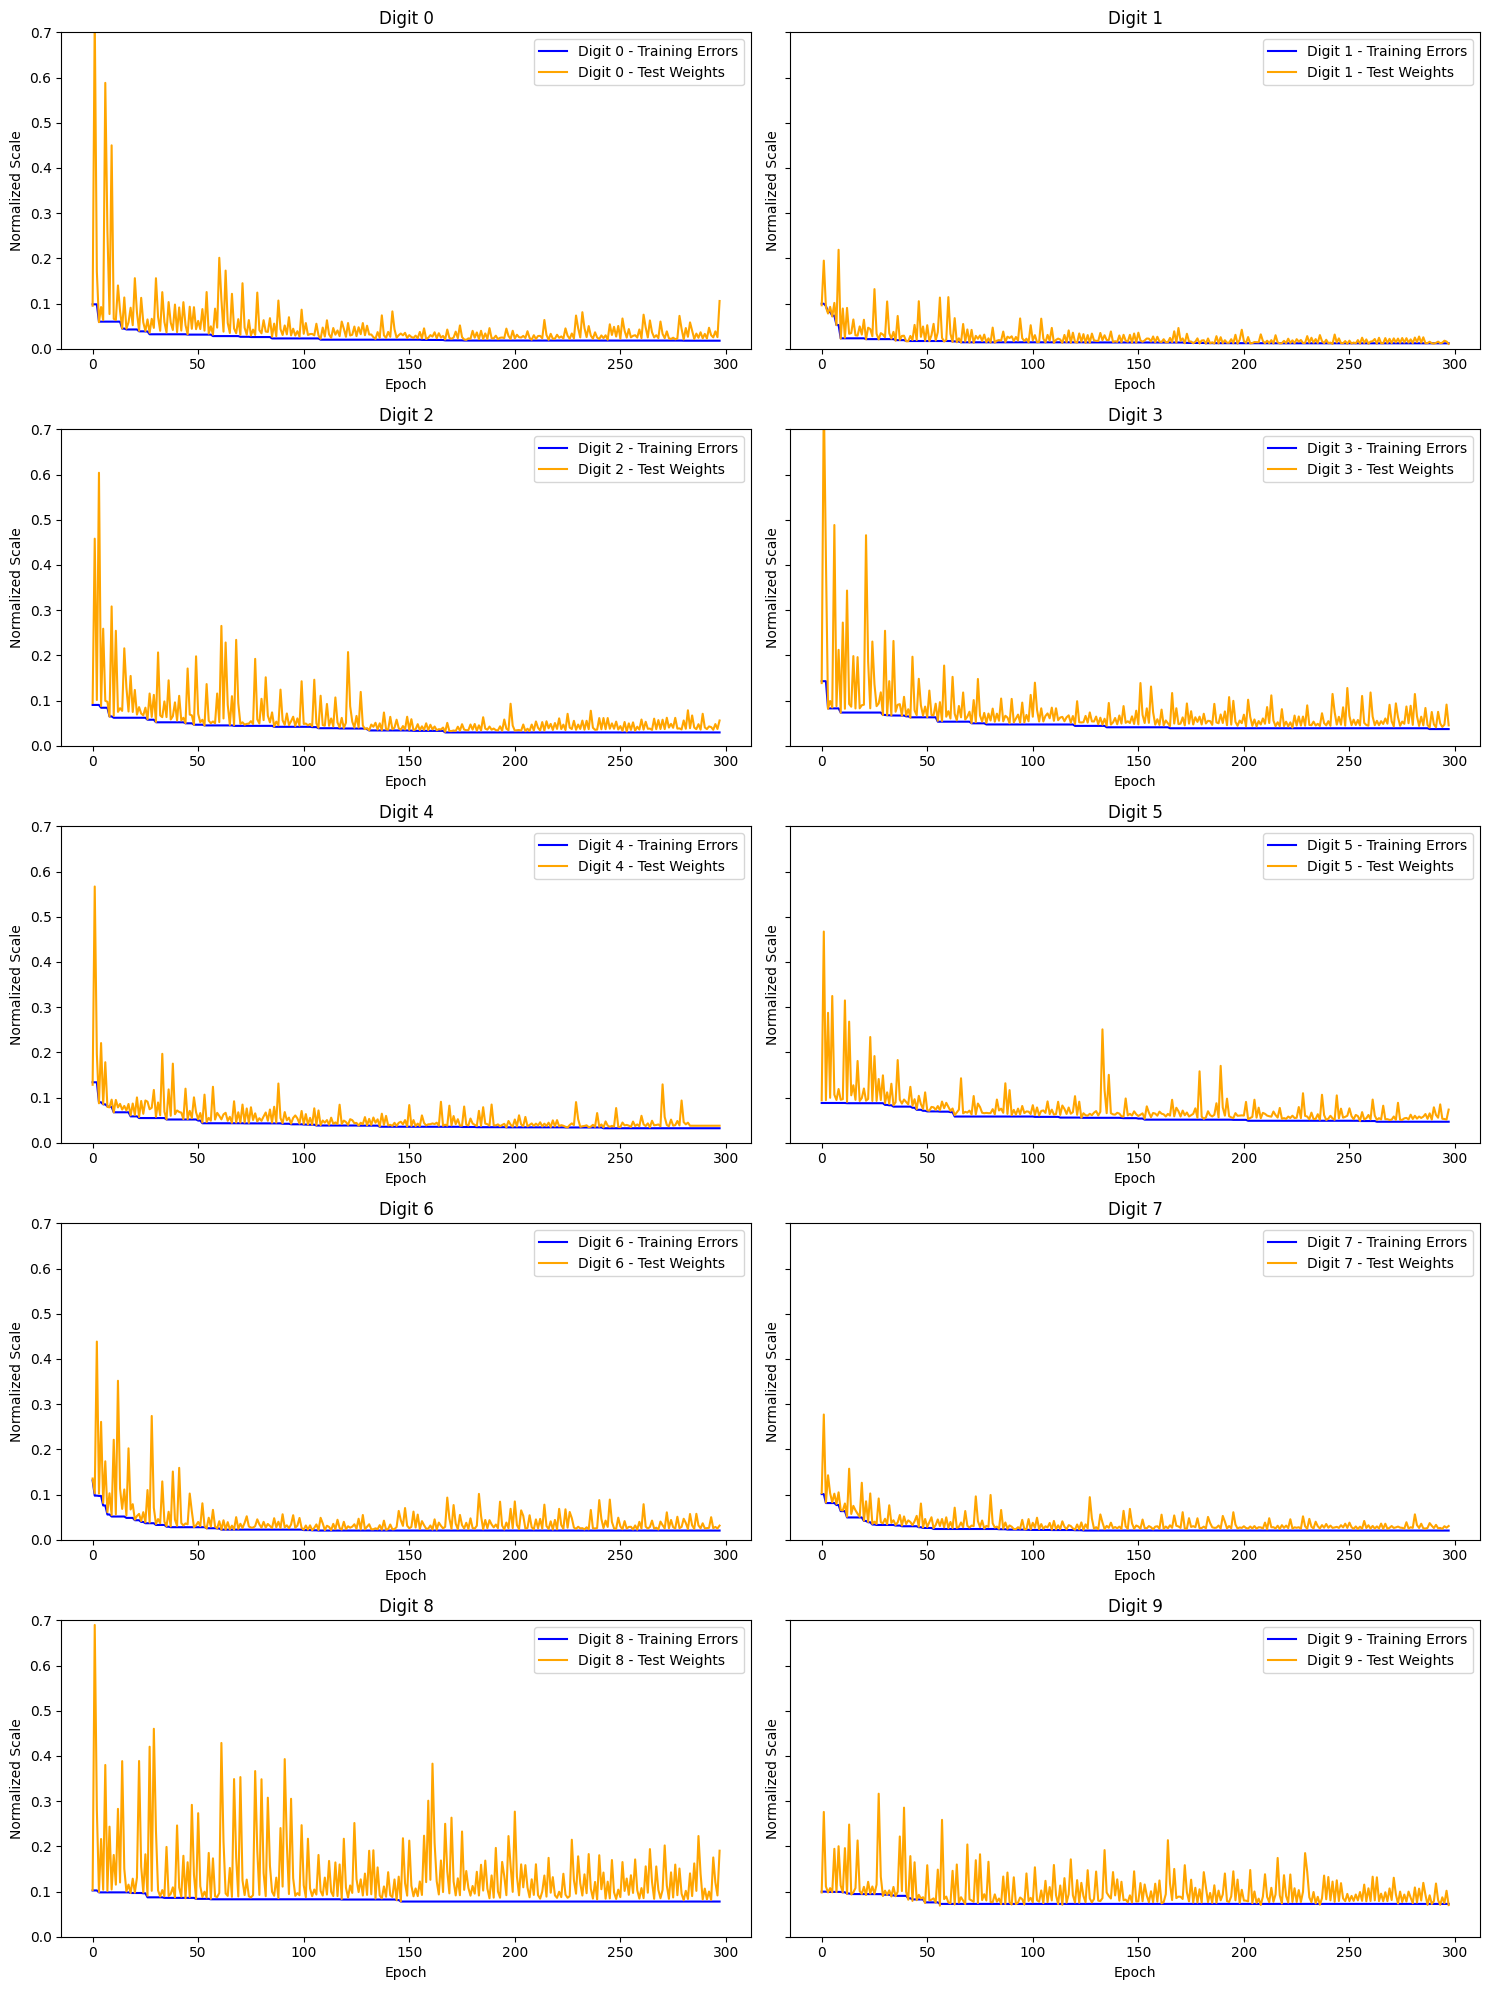

In [20]:
# Create subplots with 5 rows and 2 columns
fig, axes = plt.subplots(5, 2, figsize=(15, 20), sharey=True)
axes = axes.flatten()

# Plot errors and weights for each digit
for digit in range(10):
    row = digit // 2  # Determine the row based on the digit
    col = digit % 2   # Determine the column based on the digit

    ax = axes[row * 2 + col]

    # Plot training errors
    ax.plot(training_errors_per_digit[digit][2:], label=f'Digit {digit} - Training Errors', color='blue')

    # Plot test weights
    ax.plot(test_errors_per_digit[digit][2:], label=f'Digit {digit} - Test Weights', color='orange')

    ax.set_title(f'Digit {digit}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Normalized Scale')

    # Add legend
    ax.legend()

    # Adjust y-axis limits for zooming in
    ax.set_ylim(0, 0.7)  # Adjust these limits based on your preference

# Adjust layout
plt.tight_layout()
plt.show()


# Confusion Matrix For Multiclass Classifier -
Now we going to generate a confusion matrix to evaluate the performance of the trained classifier on the test dataset. The confusion matrix is calculated by comparing the predicted and actual labels for each instance in the test set. Additionally, the accuracy of the classifier is computed.
We can see a few things in this matrix -


*   The diagonal elements of the confusion matrix represent correct predictions for each digit, while off-diagonal elements indicate misclassifications.
*   By examining these elements, we can identify which digits the model predicts accurately and where it tends to make errors, for example we can see that the model predict 4 when its 9 alot of times.


Insights gained from the confusion matrix can guide further model refinement. For example, if certain digit pairs are consistently confused, additional data collection or feature engineering may be considered to address these challenges.

Overall, the outcomes are quite good, with an accuracy hovering around 80%. Notably, the diagonal elements are significantly higher values compared to the rest of the matrix cells.

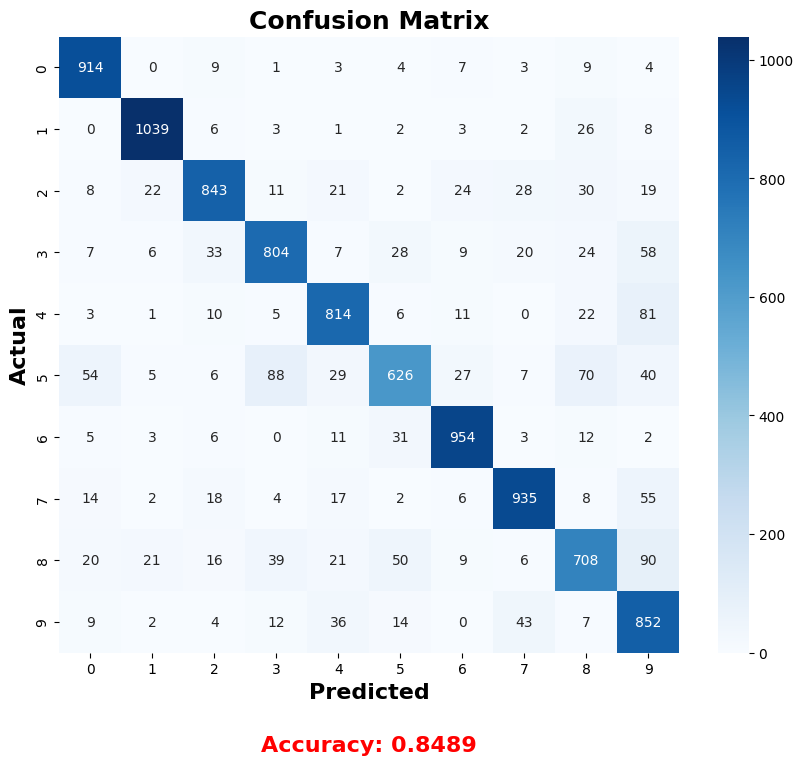

In [21]:
def get_confusion_matrix():
    confusion_matrix = np.zeros((10, 10), dtype=int)

    # Iterating through each test example in X_test
    for i in range(X_test.shape[0]):
        # Generating predictions for each digit using the dot product with corresponding classifiers
        predictions = [np.dot(X_test[i], w) for w in w_classifiers]

        # Determining the predicted digit by selecting the one with the highest score
        y_pred = np.argmax(predictions)

        # Extracting the actual digit from the one-hot encoded ground truth
        y_actual = np.argmax(y_test_one_hot_np[i])

        # Updating the confusion matrix based on the actual and predicted digits
        confusion_matrix[y_actual, y_pred] += 1

    # Returning the populated confusion matrix
    return confusion_matrix



def plot_confusion_matrix(confusion_matrix):

    # Get accuracy
    accuracy = np.trace(confusion_matrix) / len(X_test)
    # Create a heatmap using seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.arange(10), yticklabels=np.arange(10))

    plt.xlabel('Predicted', fontsize=16, weight='bold')
    plt.ylabel('Actual', fontsize=16, weight='bold')
    plt.title('Confusion Matrix', fontsize=18, weight='bold')
    plt.text(5, 11.5, f"Accuracy: {accuracy:.4f}", ha='center', va='center', fontsize=16, color='red',fontweight='bold')

    plt.show()
plot_confusion_matrix(get_confusion_matrix())


To understand why the model might misclassify 4 as 9, we'll visualize a set of randomly selected 4 digits. This exercise aims to illustrate that even for humans, distinguishing between these two digits can pose challenges.

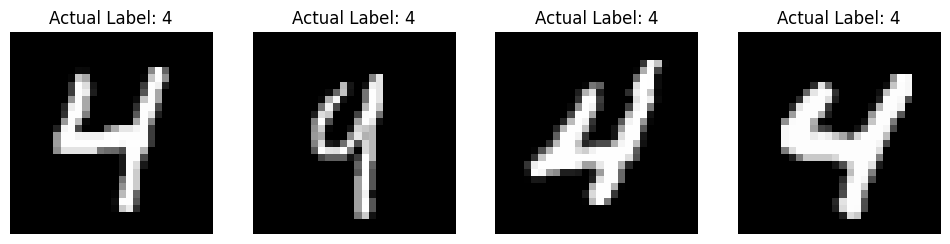

In [22]:


# Find the indices where the value is 1 in the 4th position, meaning indices of a digit "4"
indices_with_1_in_4th_position = np.where(y_test_one_hot_np[:, 4] == 1)[0]

# Randomly select 4 indices from the filtered indices
selected_indices = np.random.choice(indices_with_1_in_4th_position, size=4, replace=False)

# Plot the selected images
fig, axes = plt.subplots(1, 4, figsize=(12, 3))

for i, index in enumerate(selected_indices):
    digit_features = X_test[index, :-1].reshape(28, 28)  # -1 to take off the bias
    actual_label = np.argmax(y_test_one_hot_np[index, :])

    axes[i].imshow(digit_features, cmap='gray')
    axes[i].set_title(f"Actual Label: {actual_label}")
    axes[i].axis('off')

plt.show()

# Confusion Matrix For Binary Classification -
In this section, we present a confusion matrix for the ten binary classifiers that were previously constructed. The matrix discloses sensitivity and accuracy metrics for each digit, providing insights into the model's performance. It is noteworthy that certain digits exhibit solid accuracy but low sensitivity, such as 9. This is attributed to the model's low True Positive rate for the digit 9, as previously observed. Many instances of the digit 9 are misclassified as 4 by the model. Consequently, we can infer that the model struggles to predict true positives for the digit 9, but performs well in terms of true negatives.

In [23]:
def confusion_matrix_visualization():
    fig, axes = plt.subplots(5, 2, figsize=(12, 20))

    for digit in range(10):
        row, col = divmod(digit, 2)

        y_training_set = np.where(y_test_one_hot_np[:, digit] == 1, 1, -1)
        temp = np.dot(X_test, w_classifiers[digit])
        predict_labels = np.where(temp == 0, -1, np.sign(temp))
        true_positives = np.sum((y_training_set == 1) & (predict_labels == 1))
        true_negatives = np.sum((y_training_set == -1) & (predict_labels == -1))
        false_negatives = np.sum((y_training_set == 1) & (predict_labels == -1))
        false_positives = np.sum((y_training_set == -1) & (predict_labels == 1))
        accuracy = (true_positives + true_negatives) / (
                    true_positives + true_negatives + false_positives + false_negatives)

        # Create confusion matrix as a numpy array
        confusion_matrix = np.array([[true_positives, false_positives],
                                     [false_negatives, true_negatives]])

        # Plot confusion matrix as a heatmap with lines separating cells and no color bar
        sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Predicted Positive', 'Predicted Negative'],
                    yticklabels=['Actual Positive', 'Actual Negative'],
                    linewidths=1, linecolor='black', cbar=False, ax=axes[row, col])
        axes[row, col].set_title(f"Digit {digit}")

        # Add annotations for accuracy and sensitivity
        axes[row, col].text(0.5, 2.5, f"Accuracy: {accuracy:.4f}", ha='center', va='center', fontsize=16, color='red',fontweight='bold')
        tpr = true_positives / (true_positives + false_negatives)
        axes[row, col].text(1.5, 2.5, f"Sensitivity: {tpr:.4f}", ha='center', va='center', fontsize=16, color='green',fontweight='bold')

    plt.tight_layout()
    plt.show()


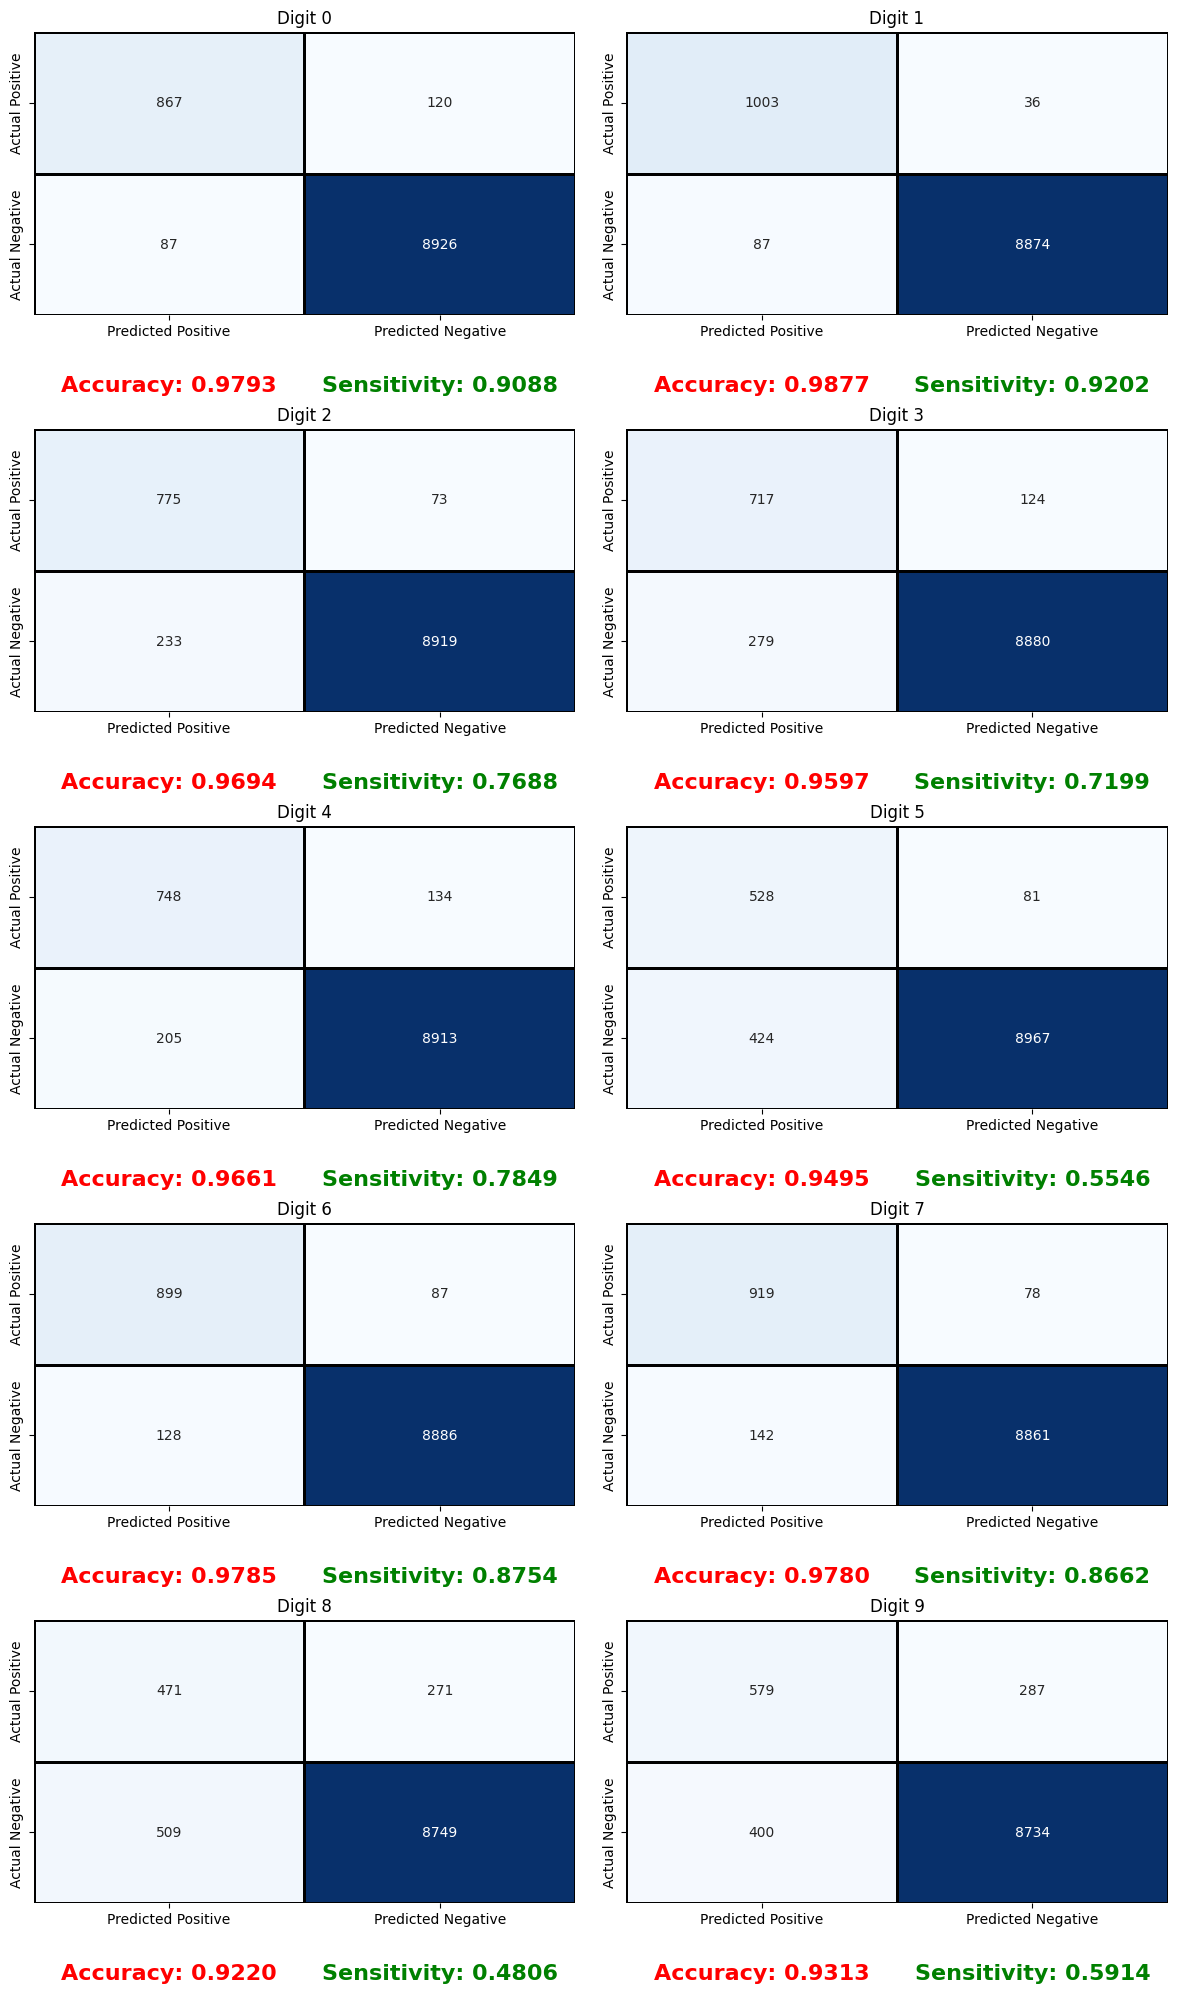

In [24]:
confusion_matrix_visualization()

In summary, the multiclass perceptron performs well for certain digits, as seen in the confusion matrix, but shows lower accuracy for others. Its suitability depends on the application's requirements. While an 80% accuracy might suffice for some purposes, precision-critical applications or those with high misclassification costs may benefit from exploring alternative models like linear or logistic regression. The optimal choice should consider the application's objectives and trade-offs between accuracy and computational complexity.

